# Recommender System

This notebook will detail all of the steps invovled in creating this music recommender system. This code is based on the google colab notebook and educational code available at: 

https://colab.research.google.com/github/google/eng-edu/blob/main/ml/recommendation-systems/recommendation-systems.ipynb?utm_source=ss-recommendation-systems&utm_campaign=colab-external&utm_medium=referral&utm_content=recommendation-systems#scrollTo=StMo4lDmLqpc 


#### The notebook is split into 4 sections:

1) Building rating matrix/ Calculating error

2) Training the matrix factorisation model

3) Inspecting embeddings

4) Regularisation in matrix factorisation


## Import required dependencies

In [1]:
from __future__ import print_function
import seaborn as sns
import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

Instructions for updating:
non-resource variables are not supported in the long term


## 1) Preliminaries

In [30]:
artists = pd.read_csv('Data/artists.dat', sep='	')
tags = pd.read_csv('Data/tags.dat', sep='	', encoding='latin-1')
user_artists = pd.read_csv('Data/user_artists.dat', sep='	')
user_friends = pd.read_csv('Data/user_friends.dat', sep='	')
user_tagged_artists_tstamp = pd.read_csv('Data/user_taggedartists-timestamps.dat', sep='	')
user_tagged_artists = pd.read_csv('Data/user_taggedartists.dat', sep='	')

We create a function to be used later for splitting the data in testing and training sets

In [31]:
# Split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test

### Building matrix

We design a function that maps the ```user_artists``` data to a tensorflow sparsetensor representation. Most users will not have rated each artist so this is full of 0's and hence becomes a very large matrix. This function allows us to efficiently capture this data

In [32]:
def build_rating_sparse_tensor(user_artists_df):
    indices = user_artists_df[['userID', 'artistID']].values
    values = user_artists_df['weight'].values
    return tf.SparseTensor(
        indices=indices,
        values=values,
        dense_shape=[len(user_artists['userID'].unique()), len(artists['id'].unique())])

### Calculating the error

The model approximates the ratings matrix $A$ by a low-rank product $UV^\top$. We need a way to measure the approximation error. We'll start by using the Mean Squared Error of observed entries only. It is defined as

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$
where $\Omega$ is the set of observed ratings, and $|\Omega|$ is the cardinality of $\Omega$.

The function below is created to calculate this

In [33]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, music_embeddings):
    predictions = tf.reduce_sum(
        tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
        tf.gather(music_embeddings, sparse_ratings.indices[:, 1]),
        axis=1)
    loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
    return loss

## 2) Training the Matrix Factorization model

### Collaborative Filtering Model (CF Model)
This class trains a matrix factorization model. Stochastic gradient descent is used in the function as the optimiser.


In [34]:
class CFModel(object):
    def __init__(self, embedding_vars, loss, metrics=None):
        self._embedding_vars = embedding_vars
        self._loss = loss
        self._metrics = metrics
        self._embeddings = {k: None for k in embedding_vars}
        self._session = None

    @property
    def embeddings(self):
        return self._embeddings

    def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
        with self._loss.graph.as_default():
            opt = optimizer(learning_rate)
            train_op = opt.minimize(self._loss)
            local_init_op = tf.group(
              tf.variables_initializer(opt.variables()),
              tf.local_variables_initializer())
            if self._session is None:
                self._session = tf.Session()
                with self._session.as_default():
                    self._session.run(tf.global_variables_initializer())
                    self._session.run(tf.tables_initializer())
                    tf.train.start_queue_runners()

        with self._session.as_default():
            local_init_op.run()
            iterations = []
            metrics = self._metrics or ({},)
            metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

            # Train and append results.
            for i in range(num_iterations + 1):
                _, results = self._session.run((train_op, metrics))
                if (i % 10 == 0) or i == num_iterations:
                    print("\r iteration %d: " % i + ", ".join(["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                        end='')
                    iterations.append(i)
                    for metric_val, result in zip(metrics_vals, results):
                        for k, v in result.items():
                            metric_val[k].append(v)

            for k, v in self._embedding_vars.items():
                self._embeddings[k] = v.eval()

            if plot_results:
                # Plot the metrics.
                num_subplots = len(metrics)+1
                fig = plt.figure()
                fig.set_size_inches(num_subplots*10, 8)
                for i, metric_vals in enumerate(metrics_vals):
                    ax = fig.add_subplot(1, num_subplots, i+1)
                    for k, v in metric_vals.items():
                        ax.plot(iterations, v, label=k)
                    ax.set_xlim([1, num_iterations])
                    ax.legend()
            return results

### Build the model

We build the model that uses the `sparse_mean_square_error` function. We write a function that builds a `CFModel` by creating the embedding variables and the train and test losses.

In [35]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
    
    # Split the ratings DataFrame into train and test.
    train_ratings, test_ratings = split_dataframe(ratings)
    # SparseTensor representation of the train and test datasets.
    A_train = build_rating_sparse_tensor(train_ratings)
    A_test = build_rating_sparse_tensor(test_ratings)
    # Initialize the embeddings using a normal distribution.
    U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
    V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
    train_loss = sparse_mean_square_error(A_train, U, V)
    test_loss = sparse_mean_square_error(A_test, U, V)
    metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
    embeddings = {
      "userID": U,
      "artistID": V
  }
    return CFModel(embeddings, train_loss, [metrics])

In [36]:
user_artists

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983
...,...,...,...
92829,2100,18726,337
92830,2100,18727,297
92831,2100,18728,281
92832,2100,18729,280


 We convert our columns into the appropriate data type before running it through the model

### Changing user id and artist id

We get errors when using the user data as is, as the user ID values and artist ID values are not in sequential order and are often higher than the index value so we will change them so they run from 0-1891, and 0-17631 respectively.

In [37]:
user_artists.userID.unique().astype(int).max()

2100

In [38]:
user_artists.artistID.unique().astype(int).max()

18745

In [39]:
def return_inverse(x):
    p = np.zeros(x.max()+1, dtype=bool)
    p[x] = 1

    p2 = np.empty(x.max()+1, dtype=np.uint64)
    c = p.sum()
    p2[p] = np.arange(c)    
    out = p2[x]
    return out

In [40]:
inverse_user_id = return_inverse(user_artists.userID)
inverse_user_id

array([   0,    0,    0, ..., 1891, 1891, 1891], dtype=uint64)

In [41]:
inverse_artist_id = return_inverse(user_artists.artistID)
inverse_artist_id

array([   45,    46,    47, ..., 17617, 17618, 17619], dtype=uint64)

In [42]:
# Replace id columns
user_artists['userID'] = inverse_user_id
user_artists['artistID'] = inverse_artist_id

In [43]:
user_artists.describe()

,userID,artistID,weight
count,92834.000000,92834.000000,92834.00000
mean,944.222483,3235.736724,745.24393
std,546.751074,4197.216910,3751.32208
min,0.000000,0.000000,1.00000
25%,470.000000,430.000000,107.00000
50%,944.000000,1237.000000,260.00000
75%,1416.000000,4266.000000,614.00000
max,1891.000000,17631.000000,352698.00000


We can see the userID now has a max value of 1,891 and artistID has a max value of 17,631

### Normalisation

The variety in weights are very large which will cause issues with our ```CFModel``` so we normalise these values between a value of 0-1 

The code below can be uncommented to try a z score normalisation for different results

In [44]:
# copy the data
user_artists_norm = user_artists.copy()
  
# apply normalization techniques by Column weight
column = 'weight'
user_artists_norm[column] = (user_artists_norm[column] - user_artists_norm[column].min()) / (user_artists_norm[column].max() - user_artists_norm[column].min())    

# z score normalisation
#user_artists_norm[column] = (user_artists_norm[column] - user_artists_norm[column].mean()) / user_artists_norm[column].std()    
  
# view normalized data
user_artists_norm.head()

,userID,artistID,weight
0,0,45,0.039360
1,0,46,0.033142
2,0,47,0.032181
3,0,48,0.029201
4,0,49,0.025467


### Build the CF Model and train it

 iteration 1000: train_error=0.018892, test_error=0.461243

[{'train_error': 0.01889176, 'test_error': 0.46124274}]

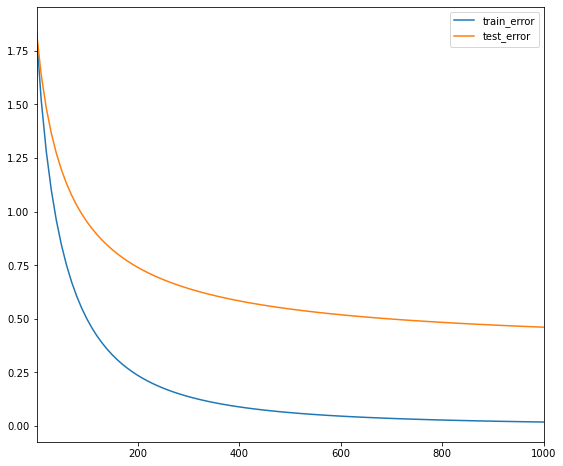

In [45]:
model = build_model(user_artists_norm, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10)

## 3) Inspecting the Embeddings

We look at the recommendations of the system using the dot product and cosine similarity which are two different similarity measures. We create a nearest neighbours function to recommend similar artists.

In [46]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):

    u = query_embedding
    V = item_embeddings
    if measure == COSINE:
        V = V / np.linalg.norm(V, axis=1, keepdims=True)
        u = u / np.linalg.norm(u)
    scores = u.dot(V.T)
    return scores

In [47]:
def artist_neighbors(model, title_substring, measure=DOT, k=6):
  ids =  artists[artists['name'].str.contains(title_substring)].index.values
  titles = artists.iloc[ids]['name'].values
  if len(titles) == 0:
    raise ValueError("Found no artists with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching artist. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  artistID = ids[0]
  scores = compute_scores(
      model.embeddings["artistID"][artistID], model.embeddings["artistID"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'names': artists['name']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

### Testing

We input an artist to see what recommendations our system returns to us

In [48]:
artist_neighbors(model, "Johnny Cash", DOT)
artist_neighbors(model, "Johnny Cash", COSINE)

Nearest neighbors of : Johnny Cash.
[Found more than one matching artist. Other candidates: Johnny Cash & Willie Nelson]


,dot score,names
1099,2.828076,Nicky Wire
2156,2.769935,Integral
6074,2.738542,The Vegas Wake Up
7141,2.732866,David Vendetta
6694,2.707119,Children of Fall
6069,2.700904,Leathermouth


Nearest neighbors of : Johnny Cash.
[Found more than one matching artist. Other candidates: Johnny Cash & Willie Nelson]


,cosine score,names
712,1.000000,Johnny Cash
15229,0.587063,Videodrone
14000,0.574917,Brazzaville
9238,0.565272,CrashDďet
10508,0.561125,Wilmie
12843,0.560648,Armand Amar


These results are interesting but it seems our system could be improved upon.

### Model initialisation

It seems the initialisation parameters may play a factor in the results of our system as artists with few ratings may have had their embeddings initialised with a high norm. We use regularisation to combat this by adjusting the value of ```init_stdev``` (previously at 0.5 now changed to 0.05)

 iteration 1000: train_error=0.000267, test_error=0.000230Nearest neighbors of : Johnny Cash.
[Found more than one matching artist. Other candidates: Johnny Cash & Willie Nelson]


,dot score,names
712,0.049078,Johnny Cash
2560,0.046092,Biffy Clyro
13796,0.043852,Peppino di Capri
7122,0.038829,Ben Lee
5444,0.037943,w-inds.
15300,0.037257,Culture


Nearest neighbors of : Johnny Cash.
[Found more than one matching artist. Other candidates: Johnny Cash & Willie Nelson]


,cosine score,names
712,1.000000,Johnny Cash
2560,0.716862,Biffy Clyro
188,0.595474,The Tiger Lillies
13796,0.595305,Peppino di Capri
9841,0.591366,Stockholm Monsters
2321,0.574845,Erkin Koray


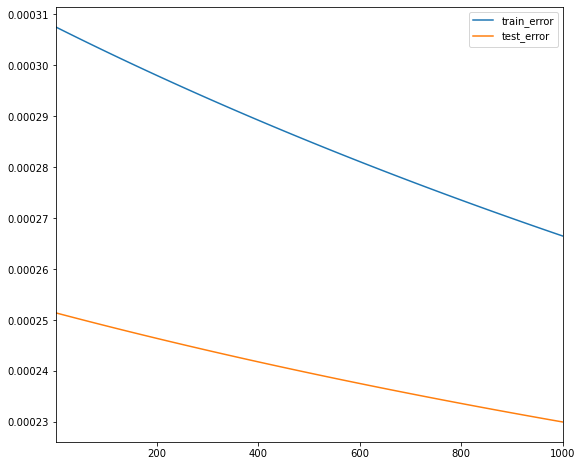

In [49]:
# Solution
model_lowinit = build_model(user_artists_norm, embedding_dim=30, init_stddev=0.05)
model_lowinit.train(num_iterations=1000, learning_rate=10.)
artist_neighbors(model_lowinit, "Johnny Cash", DOT)
artist_neighbors(model_lowinit, "Johnny Cash", COSINE)
#movie_embedding_norm([model, model_lowinit])

## 4) Regularization In Matrix Factorization

In the code above, loss was defined as the mean squared error on the observed part of the rating matrix.  This can often cause issues when the model does not learn how to place the embeddings of irrelevant artists. This is called *folding*.

We add some regularization terms to deal with this problem:
- Regularization of the model parameters. This is a common $\ell_2$ regularization term on the embedding matrices, given by $r(U, V) =  \frac{1}{N} \sum_i \|U_i\|^2 + \frac{1}{M}\sum_j \|V_j\|^2$.
- A global prior that pushes the prediction of any pair towards zero, called the *gravity* term. This is given by $g(U, V) = \frac{1}{MN} \sum_{i = 1}^N \sum_{j = 1}^M \langle U_i, V_j \rangle^2$.

Total loss can now be calculated as:
$$
\frac{1}{|\Omega|}\sum_{(i, j) \in \Omega} (A_{ij} - \langle U_i, V_j\rangle)^2 + \lambda _r r(U, V) + \lambda_g g(U, V)
$$
where $\lambda_r$ and $\lambda_g$ are two regularization coefficients (hyper-parameters).

In [50]:

def gravity(U, V):
  return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

def build_regularized_model(
    ratings, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,
    init_stddev=0.1):
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

  error_train = sparse_mean_square_error(A_train, U, V)
  error_test = sparse_mean_square_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U*U)/U.shape[0].value + tf.reduce_sum(V*V)/V.shape[0].value)
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error_observed': error_train,
      'test_error_observed': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"userId": U, "artistID": V}

  return CFModel(embeddings, total_loss, [losses, loss_components])

We build the regularised model and observe the results

 iteration 2000: train_error_observed=0.000124, test_error_observed=0.000041, observed_loss=0.000124, regularization_loss=0.003518, gravity_loss=0.000000

[{'train_error_observed': 0.00012389044, 'test_error_observed': 4.1243988e-05},
 {'observed_loss': 0.00012389044,
  'regularization_loss': 0.0035177122,
  'gravity_loss': 2.569125e-08}]

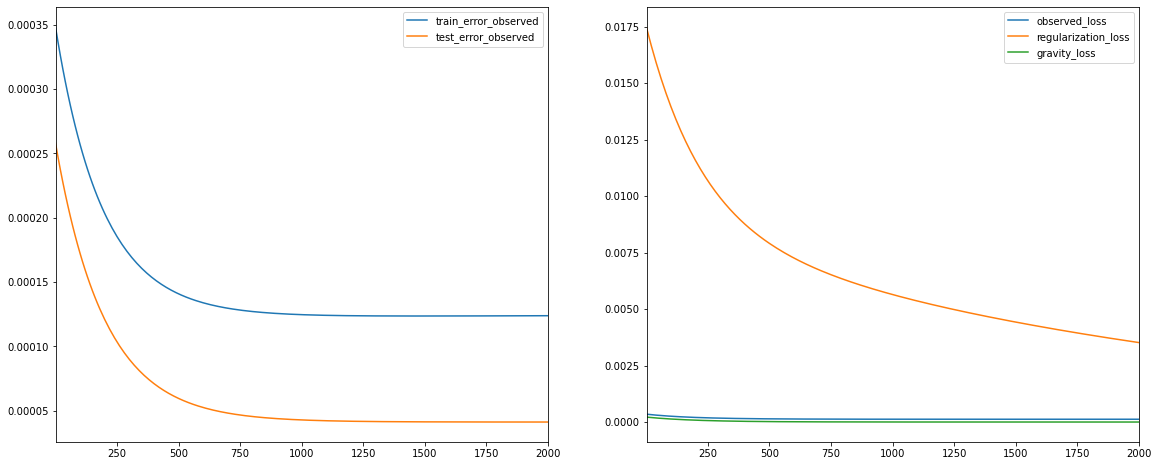

In [51]:
reg_model = build_regularized_model(
    user_artists_norm, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35,
    init_stddev=.05)
reg_model.train(num_iterations=2000, learning_rate=20.)

### Testing

In [52]:
artist_neighbors(model_lowinit, "Johnny Cash", DOT)
artist_neighbors(model_lowinit, "Johnny Cash", COSINE)

Nearest neighbors of : Johnny Cash.
[Found more than one matching artist. Other candidates: Johnny Cash & Willie Nelson]


,dot score,names
712,0.049078,Johnny Cash
2560,0.046092,Biffy Clyro
13796,0.043852,Peppino di Capri
7122,0.038829,Ben Lee
5444,0.037943,w-inds.
15300,0.037257,Culture


Nearest neighbors of : Johnny Cash.
[Found more than one matching artist. Other candidates: Johnny Cash & Willie Nelson]


,cosine score,names
712,1.000000,Johnny Cash
2560,0.716862,Biffy Clyro
188,0.595474,The Tiger Lillies
13796,0.595305,Peppino di Capri
9841,0.591366,Stockholm Monsters
2321,0.574845,Erkin Koray


## Results

Our recommender system is fully functional and outputs artists based on similarity metrics to whatever artist the user enters. The system appears to have some issues as there are often useful recommendations alongside other, not so useful recommendations. The inner workings of the systems need some work before this would be deemed acceptable however as a starting point it is a useful recommender system to be further fine tuned.

# Novel Lyrics Display

This section details the novel lyrics aspect of this system. A user can input a favourite artist and song and will be returned some classic lyrics from that artist on screen.

In [94]:
pip install lyricsgenius

Note: you may need to restart the kernel to use updated packages.


In [96]:
import os
import json
import time

Token has been removed below after successfully running the API call

In [97]:
token = 'xxxxxxxxxxxxxxxxxxxxxxxxxxx'

In [98]:
import lyricsgenius as lg
genius = lg.Genius(token)

In [99]:
song_title = "Walk the line"
artist_name = "Johnny Cash"

In [100]:
song = genius.search_song(title=song_title, artist=artist_name)

Searching for "Walk the line" by Johnny Cash...
Done.


In [101]:
lyrics = song.lyrics

In [105]:
l=lyrics.split('\n')

In [106]:
for line in l:
    print(line)
    time.sleep(2)

[Verse 1]
I keep a close watch on this heart of mine
I keep my eyes wide open all the time
I keep the ends out for the tie that binds
Because you're mine, I walk the line

[Verse 2]
I find it very, very easy to be true
I find myself alone when each day is through
Yes, I'll admit that I'm a fool for you
Because you're mine, I walk the line

[Verse 3]
As sure as night is dark and day is light
I keep you on my mind both day and night
And happiness I've known proves that it's right
Because you're mine, I walk the line

[Verse 4]
You've got a way to keep me on your side
You give me cause for love that I can't hide
For you, I know I'd even try to turn the tide
Because you're mine, I walk the line

[Verse 1]
I keep a close watch on this heart of mine
I keep my eyes wide open all the time
I keep the ends out for the tie that binds
Because you're mine, I walk the line22EmbedShare URLCopyEmbedCopy


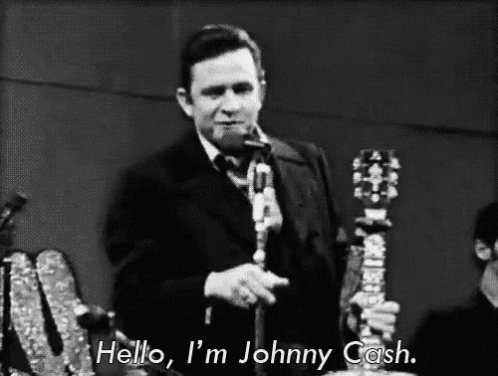

In [110]:
from IPython.display import Image
Image('https://c.tenor.com/hk7bhSzv2tgAAAAC/johnny-cash.gif')